In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score
from sqlalchemy import create_engine
from sklearn.model_selection import GridSearchCV

# Function to record performance metrics to a CSV
def log_results_to_csv(model_name, hyperparameters, accuracy, auc, sensitivity, specificity, confusion_matrix, classification_report, filename='(Full_Dataset)f_model_eval_log.csv'):
    results = {
        'Model': model_name,
        'Hyperparameters': str(hyperparameters),
        'Accuracy': accuracy,
        'AUC': auc,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Confusion Matrix': str(confusion_matrix),
        'Classification Report': str(classification_report)
    }
    # Convert to DataFrame and append
    results_df = pd.DataFrame([results])
    
    try:
        results_df.to_csv(filename, mode='a', header=False, index=False)
    except FileNotFoundError:
        # If file doesn't exist, create it with headers
        results_df.to_csv(filename, mode='w', header=True, index=False)

# Load the diabetes dataset
engine = create_engine('sqlite:///(Full_Dataset)diabetesData.db')
diabetes_df = pd.read_sql_query('select * from diabetes', con=engine)

# Define features set and target vector
X = diabetes_df.drop("diabetes", axis=1)
y = diabetes_df["diabetes"].to_numpy()

# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

# Standard scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Model 1. Random Forest

In [2]:
# --- Model 1: Initial Random Forest Classifier (Baseline Model) ---
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)
rf_model.fit(X_train_scaled, y_train)

# Make predictions and evaluate model
predictions = rf_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, predictions)
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
classification_rep = classification_report(y_test, predictions)

# Calculate AUC: ROC-AUC score for binary classification
auc_rf = roc_auc_score(y_test, rf_model.predict_proba(X_test_scaled)[:, 1])

# Calculate sensitivity and specificity:
TN, FP, FN, TP = cm.ravel()
sensitivity_rf = TP / (TP + FN)
specificity_rf = TN / (TN + FP)

# Log results for the baseline model to csv
log_results_to_csv('RandomForestClassifier', {'n_estimators': 500}, accuracy, auc_rf, sensitivity_rf, specificity_rf, cm_df, classification_rep)

Model 2. Logistic Regression

In [3]:
# --- Model 2: Logistic Regression ---
lr_model = LogisticRegression(random_state=78)
lr_model.fit(X_train_scaled, y_train)

# Make predictions and evaluate model
predictions_lr = lr_model.predict(X_test_scaled)
accuracy_lr = accuracy_score(y_test, predictions_lr)
cm_lr = confusion_matrix(y_test, predictions_lr)
cm_df_lr = pd.DataFrame(cm_lr, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
classification_rep_lr = classification_report(y_test, predictions_lr)

# Calculate AUC: ROC-AUC score for binary classification
auc_lr = roc_auc_score(y_test, lr_model.predict_proba(X_test_scaled)[:, 1])

# Calculate sensitivity and specificity:
TN, FP, FN, TP = cm_lr.ravel()
sensitivity_lr = TP / (TP + FN)
specificity_lr = TN / (TN + FP)

# Log results for the Logistic Regression model to csv
log_results_to_csv('LogisticRegression', {'solver': 'lbfgs'}, accuracy_lr, auc_lr, sensitivity_lr, specificity_lr, cm_df_lr, classification_rep_lr)

In [4]:
# --- Model 2.5: Optimized Logistic Regression ---

# Hyperparameter grid for LogisticRegression
param_grid_lr = {
    'C': [1e-4, 0.01, 0.1, 1, 10],
    'penalty': [None, 'l1', 'l2', 'elasticnet'],
    'solver': ['liblinear', 'lbfgs', 'sag', 'saga']
}

# GridSearchCV for LogisticRegression
lr_grid_search = GridSearchCV(LogisticRegression(random_state=78), param_grid_lr, cv=5, n_jobs=-1, scoring='accuracy')
lr_grid_search.fit(X_train_scaled, y_train)

# Best model after GridSearchCV
lr_optimized = lr_grid_search.best_estimator_

# Log results for the optimized Logistic Regression model
predictions_lr_optimized = lr_optimized.predict(X_test_scaled)
accuracy_lr_optimized = accuracy_score(y_test, predictions_lr_optimized)
cm_lr_optimized = confusion_matrix(y_test, predictions_lr_optimized)
cm_df_lr_opt = pd.DataFrame(cm_lr_optimized, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
classification_rep_lr_opt = classification_report(y_test, predictions_lr_optimized)

# Calculate AUC: ROC-AUC score for binary classification
auc_lr_opt = roc_auc_score(y_test, lr_optimized.predict_proba(X_test_scaled)[:, 1])

# Calculate sensitivity and specificity:
TN, FP, FN, TP = cm_lr.ravel()
sensitivity_lr_opt = TP / (TP + FN)
specificity_lr_opt = TN / (TN + FP)

# Log the results of the  optimized Logistic Regression Model to csv
log_results_to_csv('LogisticRegression_Optimized', lr_grid_search.best_params_, accuracy_lr_optimized, auc_lr_opt, sensitivity_lr_opt, specificity_lr_opt, cm_df_lr_opt, classification_rep_lr_opt)

c:\Users\nfsab\anaconda3\envs\dev\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
175 fits failed out of a total of 400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\nfsab\anaconda3\envs\dev\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\nfsab\anaconda3\envs\dev\lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\nfsab\anaconda3\envs\dev\lib\site-packages\sklearn\linear_model\_logistic.py", line 1172, in fit
    solver = _check_solver

Model 3. Decision Tree

In [5]:
# --- Model 3: Decision Tree Classifier ---
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(random_state=78)
dt_model.fit(X_train_scaled, y_train)

# Make predictions and evaluate model
predictions_dt = dt_model.predict(X_test_scaled)
accuracy_dt = accuracy_score(y_test, predictions_dt)
cm_dt = confusion_matrix(y_test, predictions_dt)
cm_df_dt = pd.DataFrame(cm_dt, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
classification_rep_dt = classification_report(y_test, predictions_dt)

# Calculate AUC: ROC-AUC score for binary classification
auc_dt = roc_auc_score(y_test, dt_model.predict_proba(X_test_scaled)[:, 1])

# Calculate sensitivity and specificity:
TN, FP, FN, TP = cm_dt.ravel()
sensitivity_dt = TP / (TP + FN)
specificity_dt = TN / (TN + FP)

# Log the results of the Decision Tree Classifier model to csv
log_results_to_csv('DecisionTreeClassifier', {'max_depth': None}, accuracy_dt, auc_dt, sensitivity_dt, specificity_dt, cm_df_dt, classification_rep_dt)

In [6]:
# --- Model 3.5: Decision Tree Classifier Optimized ---

# Hyperparameter grid for DecisionTreeClassifier
param_grid_dt = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [None, 2, 5, 10],
    'min_samples_leaf': [None, 1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

# GridSearchCV for DecisionTreeClassifier
dt_grid_search = GridSearchCV(DecisionTreeClassifier(random_state=78), param_grid_dt, cv=5, n_jobs=-1, scoring='accuracy')
dt_grid_search.fit(X_train_scaled, y_train)

# Best model after GridSearchCV
dt_optimized = dt_grid_search.best_estimator_

# Log results for the optimized DecisionTreeClassifier model
predictions_dt_optimized = dt_optimized.predict(X_test_scaled)
accuracy_dt_optimized = accuracy_score(y_test, predictions_dt_optimized)
cm_dt_optimized = confusion_matrix(y_test, predictions_dt_optimized)
cm_df_dt_opt = pd.DataFrame(cm_dt_optimized, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
classification_rep_dt_opt = classification_report(y_test, predictions_dt_optimized)

# Calculate AUC: ROC-AUC score for binary classification
auc_dt_opt = roc_auc_score(y_test, dt_optimized.predict_proba(X_test_scaled)[:, 1])

# Calculate sensitivity and specificity:
TN, FP, FN, TP = cm_dt_optimized.ravel()
sensitivity_dt_opt = TP / (TP + FN)
specificity_dt_opt = TN / (TN + FP)

# Log results for the optimized DecisionTreeClassifier model to csv
log_results_to_csv('DecisionTreeClassifier_Optimized', dt_grid_search.best_params_, accuracy_dt_optimized, auc_dt_opt, sensitivity_dt_opt, specificity_dt_opt, cm_df_dt_opt, classification_rep_dt_opt)

c:\Users\nfsab\anaconda3\envs\dev\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
420 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
240 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\nfsab\anaconda3\envs\dev\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\nfsab\anaconda3\envs\dev\lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\nfsab\anaconda3\envs\dev\lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\U

Model 4. SVC/SVM Model -- Removed, too intensive for dataset of this size

Model 5. KNearestNeighbors

In [7]:
# --- Model 5: KNNeighbors Model ---
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)

# Make predictions and evaluate model
predictions_knn = knn_model.predict(X_test_scaled)
accuracy_knn = accuracy_score(y_test, predictions_knn)
cm_knn = confusion_matrix(y_test, predictions_knn)
cm_df_knn = pd.DataFrame(cm_knn, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
classification_rep_knn = classification_report(y_test, predictions_knn)

# Calculate AUC: ROC-AUC score for binary classification
auc_knn = roc_auc_score(y_test, knn_model.predict_proba(X_test_scaled)[:, 1])

# Calculate sensitivity and specificity:
TN, FP, FN, TP = cm_knn.ravel()
sensitivity_knn = TP / (TP + FN)
specificity_knn = TN / (TN + FP)

# Log the results of the KNN Model to csv
log_results_to_csv('KNN', {'n_neighbors': 5}, accuracy_knn, auc_knn, sensitivity_knn, specificity_knn, cm_df_knn, classification_rep_knn)

Model 6. GaussianNB

In [8]:
# --- Model 6: Naive Bayes/GaussianNB Model ---
from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()
nb_model.fit(X_train_scaled, y_train)

# Make predictions and evaluate model
predictions_nb = nb_model.predict(X_test_scaled)
accuracy_nb = accuracy_score(y_test, predictions_nb)
cm_nb = confusion_matrix(y_test, predictions_nb)
cm_df_nb = pd.DataFrame(cm_nb, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
classification_rep_nb = classification_report(y_test, predictions_nb)

# Calculate AUC: ROC-AUC score for binary classification
auc_nb = roc_auc_score(y_test, nb_model.predict_proba(X_test_scaled)[:, 1])

# Calculate sensitivity and specificity:
TN, FP, FN, TP = cm_nb.ravel()
sensitivity_nb = TP / (TP + FN)
specificity_nb = TN / (TN + FP)

# Log the results of the GaussianNB Model to csv
log_results_to_csv('GaussianNB', {}, accuracy_nb, auc_nb, sensitivity_nb, specificity_nb, cm_df_nb, classification_rep_nb)

Model 7. Gradient Boosting Classifier

In [9]:
# --- Model 7: Gradient Boosting Model ---
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(random_state=78)
gb_model.fit(X_train_scaled, y_train)

# Make predictions and evaluate model
predictions_gb = gb_model.predict(X_test_scaled)
accuracy_gb = accuracy_score(y_test, predictions_gb)
cm_gb = confusion_matrix(y_test, predictions_gb)
cm_df_gb = pd.DataFrame(cm_gb, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
classification_rep_gb = classification_report(y_test, predictions_gb)

# Calculate AUC: ROC-AUC score for binary classification
auc_gb = roc_auc_score(y_test, gb_model.predict_proba(X_test_scaled)[:, 1])

# Calculate sensitivity and specificity:
TN, FP, FN, TP = cm_gb.ravel()
sensitivity_gb = TP / (TP + FN)
specificity_gb = TN / (TN + FP)

# Log the results of the Gradient Boosting Model to csv
log_results_to_csv('GradientBoostingClassifier', {}, accuracy_gb, auc_gb, sensitivity_gb, specificity_gb, cm_df_gb, classification_rep_gb)

Model 8. AdaBoost Classifier

In [10]:
# --- Model 8: AdaBoost Classifier ---
from sklearn.ensemble import AdaBoostClassifier

ab_model = AdaBoostClassifier(random_state=78)
ab_model.fit(X_train_scaled, y_train)

# Make predictions and evaluate model
predictions_ab = ab_model.predict(X_test_scaled)
accuracy_ab = accuracy_score(y_test, predictions_ab)
cm_ab = confusion_matrix(y_test, predictions_ab)
cm_df_ab = pd.DataFrame(cm_ab, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
classification_rep_ab = classification_report(y_test, predictions_ab)

# Calculate AUC: ROC-AUC score for binary classification
auc_ab = roc_auc_score(y_test, ab_model.predict_proba(X_test_scaled)[:, 1])

# Calculate sensitivity and specificity:
TN, FP, FN, TP = cm_ab.ravel()
sensitivity_ab = TP / (TP + FN)
specificity_ab = TN / (TN + FP)

# Log the results of the AdaBoost Model to csv
log_results_to_csv('AdaBoostClassifier', {}, accuracy_ab, auc_ab, sensitivity_ab, specificity_ab, cm_df_ab, classification_rep_ab)

c:\Users\nfsab\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [11]:
# --- Model 8.5: AdaBoost Classifier Optimized ---

# Hyperparameter grid for AdaBoostClassifier
param_grid_ab = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1]
}

# GridSearchCV for AdaBoostClassifier
ab_grid_search = GridSearchCV(AdaBoostClassifier(random_state=78), param_grid_ab, cv=5, n_jobs=-1, scoring='accuracy')
ab_grid_search.fit(X_train_scaled, y_train)

# Best model after GridSearchCV
ab_optimized = ab_grid_search.best_estimator_

# Log results for the optimized AdaBoost model
predictions_ab_optimized = ab_optimized.predict(X_test_scaled)
accuracy_ab_optimized = accuracy_score(y_test, predictions_ab_optimized)
cm_ab_optimized = confusion_matrix(y_test, predictions_ab_optimized)
cm_df_ab_opt = pd.DataFrame(cm_ab_optimized, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
classification_rep_ab_opt = classification_report(y_test, predictions_ab_optimized)

# Calculate AUC: ROC-AUC score for binary classification
auc_ab_opt = roc_auc_score(y_test, ab_optimized.predict_proba(X_test_scaled)[:, 1])

# Calculate sensitivity and specificity:
TN, FP, FN, TP = cm_ab_optimized.ravel()
sensitivity_ab_opt = TP / (TP + FN)
specificity_ab_opt = TN / (TN + FP)

# Log the results of the AdaBoost Optimized Model to csv
log_results_to_csv('AdaBoostClassifier_Optimized', ab_grid_search.best_params_, accuracy_ab_optimized, auc_ab_opt, sensitivity_ab_opt, specificity_ab_opt, cm_df_ab_opt, classification_rep_ab_opt)

c:\Users\nfsab\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Model 9. XGBoost

In [12]:
# --- Model 9: XGBoost Model ---
import xgboost as xgb

xgb_model = xgb.XGBClassifier(random_state=78)
xgb_model.fit(X_train_scaled, y_train)

# Make predictions and evaluate model
predictions_xgb = xgb_model.predict(X_test_scaled)
accuracy_xgb = accuracy_score(y_test, predictions_xgb)
cm_xgb = confusion_matrix(y_test, predictions_xgb)
cm_df_xgb = pd.DataFrame(cm_xgb, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
classification_rep_xgb = classification_report(y_test, predictions_xgb)

# Calculate AUC: ROC-AUC score for binary classification
auc_xgb = roc_auc_score(y_test, xgb_model.predict_proba(X_test_scaled)[:, 1])

# Calculate sensitivity and specificity:
TN, FP, FN, TP = cm_xgb.ravel()
sensitivity_xgb = TP / (TP + FN)
specificity_xgb = TN / (TN + FP)

# Log the results of the XGBoost Model to csv
log_results_to_csv('XGBoostClassifier', {}, accuracy_xgb, auc_xgb, sensitivity_xgb, specificity_xgb, cm_df_xgb, classification_rep_xgb)

In [13]:
# --- Model 9.5: XGBoost Model Optimized ---

# Hyperparameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 10],
    'subsample': [0.8, 0.9, 1.0]
}

# GridSearchCV for XGBoost
xgb_grid_search = GridSearchCV(xgb.XGBClassifier(random_state=78), param_grid_xgb, cv=5, n_jobs=-1, scoring='accuracy')
xgb_grid_search.fit(X_train_scaled, y_train)

# Best model after GridSearchCV
xgb_optimized = xgb_grid_search.best_estimator_

# Log results for the optimized XGBoost model
predictions_xgb_optimized = xgb_optimized.predict(X_test_scaled)
accuracy_xgb_optimized = accuracy_score(y_test, predictions_xgb_optimized)
cm_xgb_optimized = confusion_matrix(y_test, predictions_xgb_optimized)
cm_df_xgb_opt = pd.DataFrame(cm_xgb_optimized, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
classification_rep_xgb_opt = classification_report(y_test, predictions_xgb_optimized)

# Calculate AUC: ROC-AUC score for binary classification
auc_xgb_opt = roc_auc_score(y_test, xgb_optimized.predict_proba(X_test_scaled)[:, 1])

# Calculate sensitivity and specificity:
TN, FP, FN, TP = cm_xgb_optimized.ravel()
sensitivity_xgb_opt = TP / (TP + FN)
specificity_xgb_opt = TN / (TN + FP)

# Log the results of the XGBoost Optimized Model to csv
log_results_to_csv('XGBoostClassifier_Optimized', xgb_grid_search.best_params_, accuracy_xgb_optimized, auc_xgb_opt, sensitivity_xgb_opt, specificity_xgb_opt, cm_df_xgb_opt, classification_rep_xgb_opt)

Model 10. LightGBM

In [14]:
# --- Model 10: LightGBM Model ---
import lightgbm as lgb

lgb_model = lgb.LGBMClassifier(random_state=78)
lgb_model.fit(X_train_scaled, y_train)

# Make predictions and evaluate model
predictions_lgb = lgb_model.predict(X_test_scaled)
accuracy_lgb = accuracy_score(y_test, predictions_lgb)
cm_lgb = confusion_matrix(y_test, predictions_lgb)
cm_df_lgb = pd.DataFrame(cm_lgb, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
classification_rep_lgb = classification_report(y_test, predictions_lgb)

# Calculate AUC: ROC-AUC score for binary classification
auc_lgb = roc_auc_score(y_test, lgb_model.predict_proba(X_test_scaled)[:, 1])

# Calculate sensitivity and specificity:
TN, FP, FN, TP = cm_lgb.ravel()
sensitivity_lgb = TP / (TP + FN)
specificity_lgb = TN / (TN + FP)

# Log the results of the LightGBM Model to csv
log_results_to_csv('LightGBMClassifier', {}, accuracy_lgb, auc_lgb, sensitivity_lgb, specificity_lgb, cm_df_lgb, classification_rep_lgb)

c:\Users\nfsab\anaconda3\envs\dev\lib\site-packages\dask\dataframe\_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


[LightGBM] [Info] Number of positive: 26424, number of negative: 163836
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 190260, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.138884 -> initscore=-1.824593
[LightGBM] [Info] Start training from score -1.824593


In [15]:
# --- Model 10.5: Optimized LightGBM Model ---

# Hyperparameter grid for LightGBM
param_grid_lgb = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 10],
    'num_leaves': [31, 50, 100]
}

# GridSearchCV for LightGBM
lgb_grid_search = GridSearchCV(lgb.LGBMClassifier(random_state=78), param_grid_lgb, cv=5, n_jobs=-1, scoring='accuracy')
lgb_grid_search.fit(X_train_scaled, y_train)

# Best model after GridSearchCV
lgb_optimized = lgb_grid_search.best_estimator_

# Log results for the optimized LightGBM model
predictions_lgb_optimized = lgb_optimized.predict(X_test_scaled)
accuracy_lgb_optimized = accuracy_score(y_test, predictions_lgb_optimized)
cm_lgb_optimized = confusion_matrix(y_test, predictions_lgb_optimized)
cm_df_lgb_opt = pd.DataFrame(cm_lgb_optimized, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
classification_rep_lgb_opt = classification_report(y_test, predictions_lgb_optimized)

# Calculate AUC: ROC-AUC score for binary classification
auc_lgb_opt = roc_auc_score(y_test, lgb_optimized.predict_proba(X_test_scaled)[:, 1])

# Calculate sensitivity and specificity:
TN, FP, FN, TP = cm_lgb_optimized.ravel()
sensitivity_lgb_opt = TP / (TP + FN)
specificity_lgb_opt = TN / (TN + FP)

# Log results for the optimized LightGBM model to csv
log_results_to_csv('LightGBMClassifier_Optimized', lgb_grid_search.best_params_, accuracy_lgb_optimized, auc_lgb_opt, sensitivity_lgb_opt, specificity_lgb_opt, cm_df_lgb_opt, classification_rep_lgb_opt)

[LightGBM] [Info] Number of positive: 26424, number of negative: 163836
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 190260, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.138884 -> initscore=-1.824593
[LightGBM] [Info] Start training from score -1.824593
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

# Data Visualization

Plotting the accuracy scores of all of the models

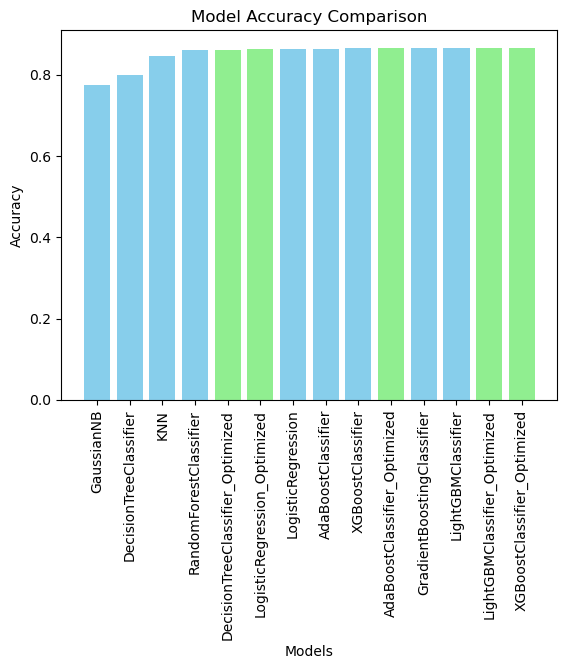

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Making the lists of models and their accuracies to zip
models = ['RandomForestClassifier', 'LogisticRegression', 'LogisticRegression_Optimized', 'DecisionTreeClassifier', 'DecisionTreeClassifier_Optimized', 'KNN', 'GaussianNB', 'GradientBoostingClassifier', 'AdaBoostClassifier', 'AdaBoostClassifier_Optimized', 'XGBoostClassifier', 'XGBoostClassifier_Optimized', 'LightGBMClassifier', 'LightGBMClassifier_Optimized']
accuracies = [accuracy, accuracy_lr, accuracy_lr_optimized, accuracy_dt, accuracy_dt_optimized, accuracy_knn, accuracy_nb, accuracy_gb, accuracy_ab, accuracy_ab_optimized, accuracy_xgb, accuracy_xgb_optimized, accuracy_lgb, accuracy_lgb_optimized]

# Combine models and accuracies into a list of tuples
model_accuracy = list(zip(models, accuracies))

# Sort the models based on accuracy (from lowest to highest)
model_accuracy.sort(key=lambda x: x[1])

# Unzip the sorted models and accuracies
sorted_models, sorted_accuracies = zip(*model_accuracy)

# Changing the colors of the columns so the the optimized ones are light green
colors = ['skyblue' if '_Optimized' not in model else 'lightgreen' for model in sorted_models]

# Plotting the sorted columns
plt.bar(sorted_models, sorted_accuracies, color= colors)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')

# Rotating the titles to make it more legible
plt.xticks(rotation=90)

plt.show()

Confirming results of the "best" model

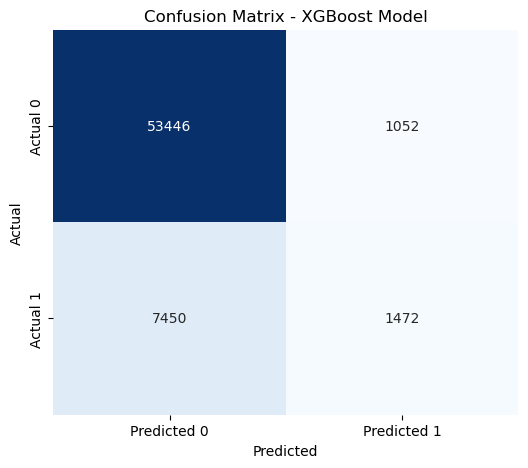

In [17]:
# Confusion matrix for XGBoost
cm_df = pd.DataFrame(cm_xgb_optimized, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

# Seaborn Confusion Matrix Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix - XGBoost Model')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Looking at Sensitivity:

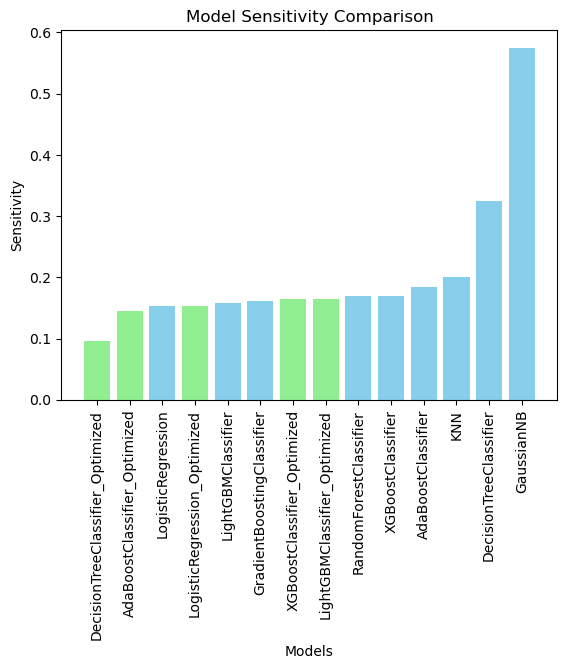

In [18]:
# Making the lists of models and their sensitivities to zip
models = ['RandomForestClassifier', 'LogisticRegression', 'LogisticRegression_Optimized', 'DecisionTreeClassifier', 'DecisionTreeClassifier_Optimized', 'KNN', 'GaussianNB', 'GradientBoostingClassifier', 'AdaBoostClassifier', 'AdaBoostClassifier_Optimized', 'XGBoostClassifier', 'XGBoostClassifier_Optimized', 'LightGBMClassifier', 'LightGBMClassifier_Optimized']
sensitivities = [sensitivity_rf, sensitivity_lr, sensitivity_lr_opt, sensitivity_dt, sensitivity_dt_opt, sensitivity_knn, sensitivity_nb, sensitivity_gb, sensitivity_ab, sensitivity_ab_opt, sensitivity_xgb, sensitivity_xgb_opt, sensitivity_lgb, sensitivity_lgb_opt]

# Combine models and sensitivities into a list of tuples
model_sensitivity = list(zip(models, sensitivities))

# Sort the models based on sensitivity (from lowest to highest)
model_sensitivity.sort(key=lambda x: x[1])

# Unzip the sorted models and accuracies
sorted_models, sorted_sensitivities = zip(*model_sensitivity)

# Changing the colors of the columns so the the optimized ones are light green
colors = ['skyblue' if '_Optimized' not in model else 'lightgreen' for model in sorted_models]

# Plotting the sorted columns
plt.bar(sorted_models, sorted_sensitivities, color= colors)
plt.xlabel('Models')
plt.ylabel('Sensitivity')
plt.title('Model Sensitivity Comparison')

# Rotating the titles to make it more legible
plt.xticks(rotation=90)

plt.show()

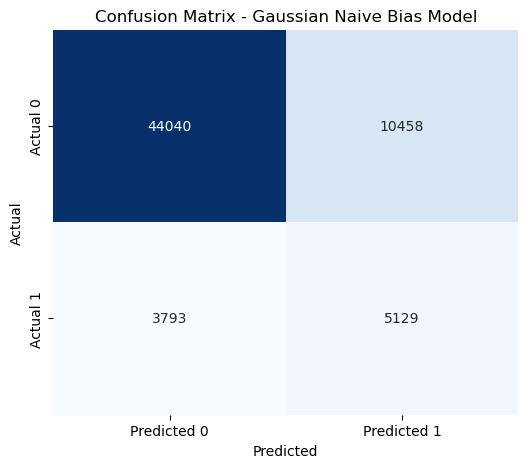

In [19]:
# Confusion matrix for GaussianNB
cm_df = pd.DataFrame(cm_nb, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

# Seaborn Confusion Matrix Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix - Gaussian Naive Bias Model')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

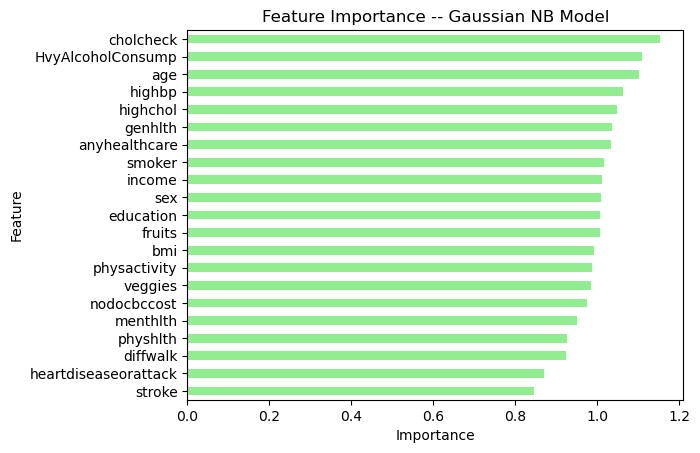

In [20]:
# Extract means and variances from the model
means = nb_model.theta_  # Mean of each feature for each class
variances = nb_model.var_  # Variance of each feature for each class

# For each feature, calculate the "importance" as the sum of absolute values of mean and variance
feature_importance = []
for i, feature in enumerate(X.columns):
    # Using the sum of the absolute values of the mean and variance for each feature
    importance = abs(means[0, i]) + abs(variances[0, i])  # For class 0, could also aggregate over classes
    feature_importance.append((feature, importance))

# Create a DataFrame for easy visualization
importances_df = pd.DataFrame(feature_importance, columns=['Feature', 'Importance'])

# Sort the features by importance
importances_sorted = importances_df.sort_values(by='Importance', ascending=True)

# Plot the sorted feature importances
importances_sorted.plot(kind='barh', x='Feature', y='Importance', color='lightgreen', title='Feature Importance -- Gaussian NB Model', xlabel='Importance', ylabel='Feature', legend=False)
plt.show()

Running an optimized verrsion of the most sensitive code:

In [21]:
# --- Model 6.5: Optimized Naive Bayes/GaussianNB Model ---

# Define the parameter grid
param_grid_nb = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

nb_grid_search = GridSearchCV(GaussianNB(), param_grid_nb, cv=5, n_jobs=-1, scoring='accuracy')
nb_grid_search.fit(X_train_scaled, y_train)

nb_model_opt = nb_grid_search.best_estimator_

# Make predictions and evaluate model
predictions_nb_opt = nb_model_opt.predict(X_test_scaled)
accuracy_nb_opt = accuracy_score(y_test, predictions_nb_opt)
cm_nb_opt = confusion_matrix(y_test, predictions_nb_opt)
cm_df_nb_opt = pd.DataFrame(cm_nb, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
classification_rep_nb_opt = classification_report(y_test, predictions_nb_opt)

# Calculate AUC: ROC-AUC score for binary classification
auc_nb_opt = roc_auc_score(y_test, nb_model_opt.predict_proba(X_test_scaled)[:, 1])

# Calculate sensitivity and specificity:
TN, FP, FN, TP = cm_nb_opt.ravel()
sensitivity_nb_opt = TP / (TP + FN)
specificity_nb_opt = TN / (TN + FP)

# Log the results of the Optimized GaussianNB Model to csv
log_results_to_csv('Optimized GaussianNB', nb_grid_search.best_estimator_, accuracy_nb_opt, auc_nb_opt, sensitivity_nb_opt, specificity_nb_opt, cm_df_nb_opt, classification_rep_nb_opt)

# SMOTE to balance out classes

Confirming the balancing

In [22]:
import numpy as np
from imblearn.over_sampling import SMOTE

# Creating the SMOTE variable and running it over our original dataset
smote = SMOTE(random_state=78)
X_train_scaled_re, y_train_re = smote.fit_resample(X_train_scaled, y_train)

# This shows the difference in size of the datasets, i.e. shows how imbalanced the original dataset is
print("Class distribution before SMOTE:", dict(zip(*np.unique(y_train, return_counts=True))))
print("Class distribution after SMOTE:", dict(zip(*np.unique(y_train_re, return_counts=True))))


Class distribution before SMOTE: {0.0: 163836, 1.0: 26424}
Class distribution after SMOTE: {0.0: 163836, 1.0: 163836}


Re-Running all of the models:

Model 1. Random Forest

In [23]:
# --- Model 1: Initial Random Forest Classifier (Baseline Model) ---
rf_model_sm = RandomForestClassifier(n_estimators=500, random_state=78)
rf_model_sm.fit(X_train_scaled_re, y_train_re)

# Make predictions and evaluate model
predictions_sm = rf_model_sm.predict(X_test_scaled)
accuracy_sm = accuracy_score(y_test, predictions_sm)
cm_sm = confusion_matrix(y_test, predictions_sm)
cm_df_sm = pd.DataFrame(cm_sm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
classification_rep_sm = classification_report(y_test, predictions_sm)

# Calculate AUC: ROC-AUC score for binary classification
auc_rf_sm = roc_auc_score(y_test, rf_model_sm.predict_proba(X_test_scaled)[:, 1])

# Calculate sensitivity and specificity:
TN, FP, FN, TP = cm_sm.ravel()
sensitivity_rf_sm = TP / (TP + FN)
specificity_rf_sm = TN / (TN + FP)

# Log results for the baseline model to csv
log_results_to_csv('SMOTE_RandomForestClassifier', {'n_estimators': 500}, accuracy_sm, auc_rf_sm, sensitivity_rf_sm, specificity_rf_sm, cm_df_sm, classification_rep_sm)

Model 2. Logistic Regression

In [24]:
# --- Model 2: Logistic Regression ---
lr_model_sm = LogisticRegression(random_state=78)
lr_model_sm.fit(X_train_scaled_re, y_train_re)

# Make predictions and evaluate model
predictions_lr_sm = lr_model_sm.predict(X_test_scaled)
accuracy_lr_sm = accuracy_score(y_test, predictions_lr_sm)
cm_lr_sm = confusion_matrix(y_test, predictions_lr_sm)
cm_df_lr_sm = pd.DataFrame(cm_lr_sm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
classification_rep_lr_sm = classification_report(y_test, predictions_lr_sm)

# Calculate AUC: ROC-AUC score for binary classification
auc_lr_sm = roc_auc_score(y_test, lr_model_sm.predict_proba(X_test_scaled)[:, 1])

# Calculate sensitivity and specificity:
TN, FP, FN, TP = cm_lr_sm.ravel()
sensitivity_lr_sm = TP / (TP + FN)
specificity_lr_sm = TN / (TN + FP)

# Log results for the Logistic Regression model to csv
log_results_to_csv('SMOTE_LogisticRegression', {'solver': 'lbfgs'}, accuracy_lr_sm, auc_lr_sm, sensitivity_lr_sm, specificity_lr_sm, cm_df_lr_sm, classification_rep_lr_sm)

In [25]:
# --- Model 2.5: Optimized Logistic Regression ---

# GridSearchCV for LogisticRegression
lr_grid_search_sm = GridSearchCV(LogisticRegression(random_state=78), param_grid_lr, cv=5, n_jobs=-1, scoring='accuracy')
lr_grid_search_sm.fit(X_train_scaled_re, y_train_re)

# Best model after GridSearchCV
lr_optimized_sm = lr_grid_search_sm.best_estimator_

# Log results for the optimized Logistic Regression model
predictions_lr_optimized_sm = lr_optimized_sm.predict(X_test_scaled)
accuracy_lr_optimized_sm = accuracy_score(y_test, predictions_lr_optimized_sm)
cm_lr_optimized_sm = confusion_matrix(y_test, predictions_lr_optimized_sm)
cm_df_lr_opt_sm = pd.DataFrame(cm_lr_optimized_sm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
classification_rep_lr_opt_sm = classification_report(y_test, predictions_lr_optimized_sm)

# Calculate AUC: ROC-AUC score for binary classification
auc_lr_opt_sm = roc_auc_score(y_test, lr_optimized_sm.predict_proba(X_test_scaled)[:, 1])

# Calculate sensitivity and specificity:
TN, FP, FN, TP = cm_lr_optimized_sm.ravel()
sensitivity_lr_opt_sm = TP / (TP + FN)
specificity_lr_opt_sm = TN / (TN + FP)

# Log the results of the  optimized Logistic Regression Model to csv
log_results_to_csv('SMOTE_LogisticRegression_Optimized', lr_grid_search_sm.best_params_, accuracy_lr_optimized_sm, auc_lr_opt_sm, sensitivity_lr_opt_sm, specificity_lr_opt_sm, cm_df_lr_opt_sm, classification_rep_lr_opt_sm)

c:\Users\nfsab\anaconda3\envs\dev\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
175 fits failed out of a total of 400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\nfsab\anaconda3\envs\dev\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\nfsab\anaconda3\envs\dev\lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\nfsab\anaconda3\envs\dev\lib\site-packages\sklearn\linear_model\_logistic.py", line 1172, in fit
    solver = _check_solver

Model 3. Decision Tree

In [26]:
# --- Model 3: Decision Tree Classifier ---
dt_model_sm = DecisionTreeClassifier(random_state=78)
dt_model_sm.fit(X_train_scaled_re, y_train_re)

# Make predictions and evaluate model
predictions_dt_sm = dt_model_sm.predict(X_test_scaled)
accuracy_dt_sm = accuracy_score(y_test, predictions_dt_sm)
cm_dt_sm = confusion_matrix(y_test, predictions_dt_sm)
cm_df_dt_sm = pd.DataFrame(cm_dt_sm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
classification_rep_dt_sm = classification_report(y_test, predictions_dt_sm)

# Calculate AUC: ROC-AUC score for binary classification
auc_dt_sm = roc_auc_score(y_test, dt_model_sm.predict_proba(X_test_scaled)[:, 1])

# Calculate sensitivity and specificity:
TN, FP, FN, TP = cm_dt_sm.ravel()
sensitivity_dt_sm = TP / (TP + FN)
specificity_dt_sm = TN / (TN + FP)

# Log the results of the Decision Tree Classifier model to csv
log_results_to_csv('SMOTE_DecisionTreeClassifier', {'max_depth': None}, accuracy_dt_sm, auc_dt_sm, sensitivity_dt_sm, specificity_dt_sm, cm_df_dt_sm, classification_rep_dt_sm)

In [27]:
# --- Model 3.5: Decision Tree Classifier Optimized ---

# GridSearchCV for DecisionTreeClassifier
dt_grid_search_sm = GridSearchCV(DecisionTreeClassifier(random_state=78), param_grid_dt, cv=5, n_jobs=-1, scoring='accuracy')
dt_grid_search_sm.fit(X_train_scaled_re, y_train_re)

# Best model after GridSearchCV
dt_optimized_sm = dt_grid_search_sm.best_estimator_

# Log results for the optimized DecisionTreeClassifier model
predictions_dt_optimized_sm = dt_optimized_sm.predict(X_test_scaled)
accuracy_dt_optimized_sm = accuracy_score(y_test, predictions_dt_optimized_sm)
cm_dt_optimized_sm= confusion_matrix(y_test, predictions_dt_optimized_sm)
cm_df_dt_opt_sm = pd.DataFrame(cm_dt_optimized_sm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
classification_rep_dt_opt_sm = classification_report(y_test, predictions_dt_optimized_sm)

# Calculate AUC: ROC-AUC score for binary classification
auc_dt_opt_sm = roc_auc_score(y_test, dt_optimized_sm.predict_proba(X_test_scaled)[:, 1])

# Calculate sensitivity and specificity:
TN, FP, FN, TP = cm_dt_optimized_sm.ravel()
sensitivity_dt_opt_sm = TP / (TP + FN)
specificity_dt_opt_sm = TN / (TN + FP)

# Log results for the optimized DecisionTreeClassifier model to csv
log_results_to_csv('SMOTE_DecisionTreeClassifier_Optimized', dt_grid_search_sm.best_params_, accuracy_dt_optimized_sm, auc_dt_opt_sm, sensitivity_dt_opt_sm, specificity_dt_opt_sm, cm_df_dt_opt_sm, classification_rep_dt_opt_sm)

c:\Users\nfsab\anaconda3\envs\dev\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
420 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
240 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\nfsab\anaconda3\envs\dev\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\nfsab\anaconda3\envs\dev\lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\nfsab\anaconda3\envs\dev\lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\U

Model 4. SVC/SVM Model -- Removed, too intensive for dataset of this size

Model 5. KNearestNeighbors

In [28]:
# --- Model 5: KNNeighbors Model ---
knn_model_sm = KNeighborsClassifier(n_neighbors=5)
knn_model_sm.fit(X_train_scaled_re, y_train_re)

# Make predictions and evaluate model
predictions_knn_sm = knn_model_sm.predict(X_test_scaled)
accuracy_knn_sm = accuracy_score(y_test, predictions_knn_sm)
cm_knn_sm = confusion_matrix(y_test, predictions_knn_sm)
cm_df_knn_sm = pd.DataFrame(cm_knn_sm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
classification_rep_knn_sm = classification_report(y_test, predictions_knn_sm)

# Calculate AUC: ROC-AUC score for binary classification
auc_knn_sm = roc_auc_score(y_test, knn_model_sm.predict_proba(X_test_scaled)[:, 1])

# Calculate sensitivity and specificity:
TN, FP, FN, TP = cm_knn_sm.ravel()
sensitivity_knn_sm = TP / (TP + FN)
specificity_knn_sm = TN / (TN + FP)

# Log the results of the KNN Model to csv
log_results_to_csv('SMOTE_KNN', {'n_neighbors': 5}, accuracy_knn_sm, auc_knn_sm, sensitivity_knn_sm, specificity_knn_sm, cm_df_knn_sm, classification_rep_knn_sm)

Model 6. GaussianNB

In [29]:
# --- Model 6: Naive Bayes/GaussianNB Model ---
nb_model_sm = GaussianNB()
nb_model_sm.fit(X_train_scaled_re, y_train_re)

# Make predictions and evaluate model
predictions_nb_sm = nb_model_sm.predict(X_test_scaled)
accuracy_nb_sm = accuracy_score(y_test, predictions_nb_sm)
cm_nb_sm = confusion_matrix(y_test, predictions_nb_sm)
cm_df_nb_sm = pd.DataFrame(cm_nb_sm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
classification_rep_nb_sm = classification_report(y_test, predictions_nb_sm)

# Calculate AUC: ROC-AUC score for binary classification
auc_nb_sm = roc_auc_score(y_test, nb_model_sm.predict_proba(X_test_scaled)[:, 1])

# Calculate sensitivity and specificity:
TN, FP, FN, TP = cm_nb_sm.ravel()
sensitivity_nb_sm = TP / (TP + FN)
specificity_nb_sm = TN / (TN + FP)

# Log the results of the GaussianNB Model to csv
log_results_to_csv('SMOTE_GaussianNB', {}, accuracy_nb_sm, auc_nb_sm, sensitivity_nb_sm, specificity_nb_sm, cm_df_nb_sm, classification_rep_nb_sm)

Model 7. Gradient Boosting Classifier

In [30]:
# --- Model 7: Gradient Boosting Model ---
gb_model_sm = GradientBoostingClassifier(random_state=78)
gb_model_sm.fit(X_train_scaled_re, y_train_re)

# Make predictions and evaluate model
predictions_gb_sm = gb_model_sm.predict(X_test_scaled)
accuracy_gb_sm = accuracy_score(y_test, predictions_gb_sm)
cm_gb_sm = confusion_matrix(y_test, predictions_gb_sm)
cm_df_gb_sm = pd.DataFrame(cm_gb_sm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
classification_rep_gb_sm = classification_report(y_test, predictions_gb_sm)

# Calculate AUC: ROC-AUC score for binary classification
auc_gb_sm = roc_auc_score(y_test, gb_model_sm.predict_proba(X_test_scaled)[:, 1])

# Calculate sensitivity and specificity:
TN, FP, FN, TP = cm_gb_sm.ravel()
sensitivity_gb_sm = TP / (TP + FN)
specificity_gb_sm = TN / (TN + FP)

# Log the results of the Gradient Boosting Model to csv
log_results_to_csv('SMOTE_GradientBoostingClassifier', {}, accuracy_gb_sm, auc_gb_sm, sensitivity_gb_sm, specificity_gb_sm, cm_df_gb_sm, classification_rep_gb_sm)

Model 8. AdaBoost Classifier

In [31]:
# --- Model 8: AdaBoost Classifier ---
ab_model_sm = AdaBoostClassifier(random_state=78)
ab_model_sm.fit(X_train_scaled_re, y_train_re)

# Make predictions and evaluate model
predictions_ab_sm = ab_model_sm.predict(X_test_scaled)
accuracy_ab_sm = accuracy_score(y_test, predictions_ab_sm)
cm_ab_sm = confusion_matrix(y_test, predictions_ab_sm)
cm_df_ab_sm = pd.DataFrame(cm_ab_sm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
classification_rep_ab_sm = classification_report(y_test, predictions_ab_sm)

# Calculate AUC: ROC-AUC score for binary classification
auc_ab_sm = roc_auc_score(y_test, ab_model_sm.predict_proba(X_test_scaled)[:, 1])

# Calculate sensitivity and specificity:
TN, FP, FN, TP = cm_ab_sm.ravel()
sensitivity_ab_sm = TP / (TP + FN)
specificity_ab_sm = TN / (TN + FP)

# Log the results of the AdaBoost Model to csv
log_results_to_csv('SMOTE_AdaBoostClassifier', {}, accuracy_ab_sm, auc_ab_sm, sensitivity_ab_sm, specificity_ab_sm, cm_df_ab_sm, classification_rep_ab_sm)

c:\Users\nfsab\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [32]:
# --- Model 8.5: AdaBoost Classifier Optimized ---

# GridSearchCV for AdaBoostClassifier
ab_grid_search_sm = GridSearchCV(AdaBoostClassifier(random_state=78), param_grid_ab, cv=5, n_jobs=-1, scoring='accuracy')
ab_grid_search_sm.fit(X_train_scaled_re, y_train_re)

# Best model after GridSearchCV
ab_optimized_sm = ab_grid_search_sm.best_estimator_

# Log results for the optimized AdaBoost model
predictions_ab_optimized_sm = ab_optimized_sm.predict(X_test_scaled)
accuracy_ab_optimized_sm = accuracy_score(y_test, predictions_ab_optimized_sm)
cm_ab_optimized_sm = confusion_matrix(y_test, predictions_ab_optimized_sm)
cm_df_ab_opt_sm = pd.DataFrame(cm_ab_optimized_sm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
classification_rep_ab_opt_sm = classification_report(y_test, predictions_ab_optimized_sm)

# Calculate AUC: ROC-AUC score for binary classification
auc_ab_opt_sm = roc_auc_score(y_test, ab_optimized_sm.predict_proba(X_test_scaled)[:, 1])

# Calculate sensitivity and specificity:
TN, FP, FN, TP = cm_ab_optimized_sm.ravel()
sensitivity_ab_opt_sm = TP / (TP + FN)
specificity_ab_opt_sm = TN / (TN + FP)

# Log the results of the AdaBoost Optimized Model to csv
log_results_to_csv('SMOTE_AdaBoostClassifier_Optimized', ab_grid_search_sm.best_params_, accuracy_ab_optimized_sm, auc_ab_opt_sm, sensitivity_ab_opt_sm, specificity_ab_opt_sm, cm_df_ab_opt_sm, classification_rep_ab_opt_sm)

c:\Users\nfsab\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Model 9. XGBoost

In [33]:
# --- Model 9: XGBoost Model ---
xgb_model_sm = xgb.XGBClassifier(random_state=78)
xgb_model_sm.fit(X_train_scaled_re, y_train_re)

# Make predictions and evaluate model
predictions_xgb_sm = xgb_model_sm.predict(X_test_scaled)
accuracy_xgb_sm = accuracy_score(y_test, predictions_xgb_sm)
cm_xgb_sm = confusion_matrix(y_test, predictions_xgb_sm)
cm_df_xgb_sm = pd.DataFrame(cm_xgb_sm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
classification_rep_xgb_sm = classification_report(y_test, predictions_xgb_sm)

# Calculate AUC: ROC-AUC score for binary classification
auc_xgb_sm = roc_auc_score(y_test, xgb_model_sm.predict_proba(X_test_scaled)[:, 1])

# Calculate sensitivity and specificity:
TN, FP, FN, TP = cm_xgb_sm.ravel()
sensitivity_xgb_sm = TP / (TP + FN)
specificity_xgb_sm = TN / (TN + FP)

# Log the results of the XGBoost Model to csv
log_results_to_csv('SMOTE_XGBoostClassifier', {}, accuracy_xgb_sm, auc_xgb_sm, sensitivity_xgb_sm, specificity_xgb_sm, cm_df_xgb_sm, classification_rep_xgb_sm)

In [34]:
# --- Model 9.5: XGBoost Model Optimized ---

# GridSearchCV for XGBoost
xgb_grid_search_sm = GridSearchCV(xgb.XGBClassifier(random_state=78), param_grid_xgb, cv=5, n_jobs=-1, scoring='accuracy')
xgb_grid_search_sm.fit(X_train_scaled_re, y_train_re)

# Best model after GridSearchCV
xgb_optimized_sm = xgb_grid_search_sm.best_estimator_

# Log results for the optimized XGBoost model
predictions_xgb_optimized_sm = xgb_optimized_sm.predict(X_test_scaled)
accuracy_xgb_optimized_sm = accuracy_score(y_test, predictions_xgb_optimized_sm)
cm_xgb_optimized_sm = confusion_matrix(y_test, predictions_xgb_optimized_sm)
cm_df_xgb_opt_sm = pd.DataFrame(cm_xgb_optimized_sm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
classification_rep_xgb_opt_sm = classification_report(y_test, predictions_xgb_optimized_sm)

# Calculate AUC: ROC-AUC score for binary classification
auc_xgb_opt_sm = roc_auc_score(y_test, xgb_optimized_sm.predict_proba(X_test_scaled)[:, 1])

# Calculate sensitivity and specificity:
TN, FP, FN, TP = cm_xgb_optimized_sm.ravel()
sensitivity_xgb_opt_sm = TP / (TP + FN)
specificity_xgb_opt_sm = TN / (TN + FP)

# Log the results of the XGBoost Optimized Model to csv
log_results_to_csv('SMOTE_XGBoostClassifier_Optimized', xgb_grid_search_sm.best_params_, accuracy_xgb_optimized_sm, auc_xgb_opt_sm, sensitivity_xgb_opt_sm, specificity_xgb_opt_sm, cm_df_xgb_opt_sm, classification_rep_xgb_opt_sm)

Model 10. LightGBM

In [35]:
# --- Model 10: LightGBM Model ---
lgb_model_sm = lgb.LGBMClassifier(random_state=78)
lgb_model_sm.fit(X_train_scaled_re, y_train_re)

# Make predictions and evaluate model
predictions_lgb_sm = lgb_model_sm.predict(X_test_scaled)
accuracy_lgb_sm = accuracy_score(y_test, predictions_lgb_sm)
cm_lgb_sm = confusion_matrix(y_test, predictions_lgb_sm)
cm_df_lgb_sm = pd.DataFrame(cm_lgb_sm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
classification_rep_lgb_sm = classification_report(y_test, predictions_lgb_sm)

# Calculate AUC: ROC-AUC score for binary classification
auc_lgb_sm = roc_auc_score(y_test, lgb_model_sm.predict_proba(X_test_scaled)[:, 1])

# Calculate sensitivity and specificity:
TN, FP, FN, TP = cm_lgb_sm.ravel()
sensitivity_lgb_sm = TP / (TP + FN)
specificity_lgb_sm = TN / (TN + FP)

# Log the results of the LightGBM Model to csv
log_results_to_csv('SMOTE_LightGBMClassifier', {}, accuracy_lgb_sm, auc_lgb_sm, sensitivity_lgb_sm, specificity_lgb_sm, cm_df_lgb_sm, classification_rep_lgb_sm)

[LightGBM] [Info] Number of positive: 163836, number of negative: 163836
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016654 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3990
[LightGBM] [Info] Number of data points in the train set: 327672, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [36]:
# --- Model 10.5: Optimized LightGBM Model ---

# GridSearchCV for LightGBM
lgb_grid_search_sm = GridSearchCV(lgb.LGBMClassifier(random_state=78), param_grid_lgb, cv=5, n_jobs=-1, scoring='accuracy')
lgb_grid_search_sm.fit(X_train_scaled_re, y_train_re)

# Best model after GridSearchCV
lgb_optimized_sm = lgb_grid_search_sm.best_estimator_

# Log results for the optimized LightGBM model
predictions_lgb_optimized_sm = lgb_optimized_sm.predict(X_test_scaled)
accuracy_lgb_optimized_sm = accuracy_score(y_test, predictions_lgb_optimized_sm)
cm_lgb_optimized_sm = confusion_matrix(y_test, predictions_lgb_optimized_sm)
cm_df_lgb_opt_sm = pd.DataFrame(cm_lgb_optimized_sm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
classification_rep_lgb_opt_sm = classification_report(y_test, predictions_lgb_optimized_sm)

# Calculate AUC: ROC-AUC score for binary classification
auc_lgb_opt_sm = roc_auc_score(y_test, lgb_optimized_sm.predict_proba(X_test_scaled)[:, 1])

# Calculate sensitivity and specificity:
TN, FP, FN, TP = cm_lgb_optimized_sm.ravel()
sensitivity_lgb_opt_sm = TP / (TP + FN)
specificity_lgb_opt_sm = TN / (TN + FP)

# Log results for the optimized LightGBM model to csv
log_results_to_csv('SMOTE_LightGBMClassifier_Optimized', lgb_grid_search_sm.best_params_, accuracy_lgb_optimized_sm, auc_lgb_opt_sm, sensitivity_lgb_opt_sm, specificity_lgb_opt_sm, cm_df_lgb_opt_sm, classification_rep_lgb_opt_sm)

[LightGBM] [Info] Number of positive: 163836, number of negative: 163836
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3990
[LightGBM] [Info] Number of data points in the train set: 327672, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

Testing model accuracies:

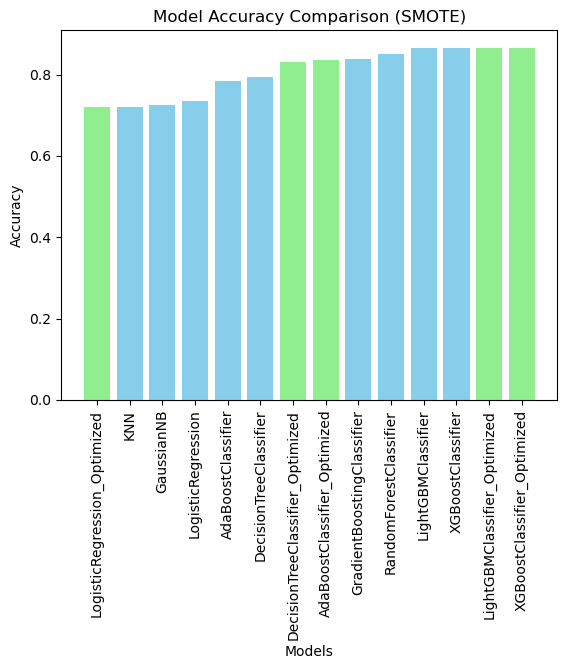

In [37]:
# Making the lists of models and their accuracies to zip
models_sm = ['RandomForestClassifier', 'LogisticRegression', 'LogisticRegression_Optimized', 'DecisionTreeClassifier', 'DecisionTreeClassifier_Optimized', 'KNN', 'GaussianNB', 'GradientBoostingClassifier', 'AdaBoostClassifier', 'AdaBoostClassifier_Optimized', 'XGBoostClassifier', 'XGBoostClassifier_Optimized', 'LightGBMClassifier', 'LightGBMClassifier_Optimized']
accuracies_sm = [accuracy_sm, accuracy_lr_sm, accuracy_lr_optimized_sm, accuracy_dt_sm, accuracy_dt_optimized_sm, accuracy_knn_sm, accuracy_nb_sm, accuracy_gb_sm, accuracy_ab_sm, accuracy_ab_optimized_sm, accuracy_xgb_sm, accuracy_xgb_optimized_sm, accuracy_lgb_sm, accuracy_lgb_optimized_sm]

# Combine models and accuracies into a list of tuples
model_accuracy_sm = list(zip(models_sm, accuracies_sm))

# Sort the models based on accuracy (from lowest to highest)
model_accuracy_sm.sort(key=lambda x: x[1])

# Unzip the sorted models and accuracies
sorted_models_sm, sorted_accuracies_sm = zip(*model_accuracy_sm)

# Changing the colors of the columns so the the optimized ones are light green
colors = ['skyblue' if '_Optimized' not in model else 'lightgreen' for model in sorted_models_sm]

# Plotting the sorted columns
plt.bar(sorted_models_sm, sorted_accuracies_sm, color= colors)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison (SMOTE)')

# Rotating the titles to make it more legible
plt.xticks(rotation=90)

plt.show()

Testing model sensitivities:

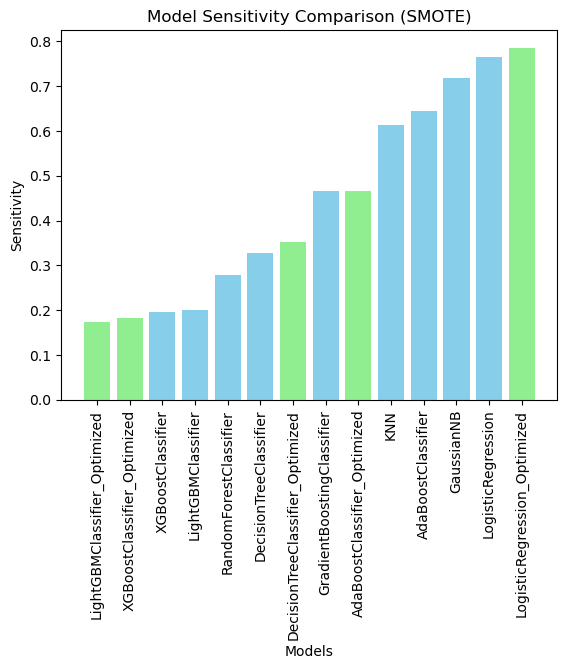

In [38]:
# Making the lists of models and their sensitivities to zip
models_sm2 = ['RandomForestClassifier', 'LogisticRegression', 'LogisticRegression_Optimized', 'DecisionTreeClassifier', 'DecisionTreeClassifier_Optimized', 'KNN', 'GaussianNB', 'GradientBoostingClassifier', 'AdaBoostClassifier', 'AdaBoostClassifier_Optimized', 'XGBoostClassifier', 'XGBoostClassifier_Optimized', 'LightGBMClassifier', 'LightGBMClassifier_Optimized']
sensitivities_sm = [sensitivity_rf_sm, sensitivity_lr_sm, sensitivity_lr_opt_sm, sensitivity_dt_sm, sensitivity_dt_opt_sm, sensitivity_knn_sm, sensitivity_nb_sm, sensitivity_gb_sm, sensitivity_ab_sm, sensitivity_ab_opt_sm, sensitivity_xgb_sm, sensitivity_xgb_opt_sm, sensitivity_lgb_sm, sensitivity_lgb_opt_sm]

# Combine models and sensitivities into a list of tuples
model_sensitivity_sm = list(zip(models_sm2, sensitivities_sm))

# Sort the models based on sensitivity (from lowest to highest)
model_sensitivity_sm.sort(key=lambda x: x[1])

# Unzip the sorted models and accuracies
sorted_models_sm, sorted_sensitivities_sm = zip(*model_sensitivity_sm)

# Changing the colors of the columns so the the optimized ones are light green
colors = ['skyblue' if '_Optimized' not in model else 'lightgreen' for model in sorted_models_sm]

# Plotting the sorted columns
plt.bar(sorted_models_sm, sorted_sensitivities_sm, color= colors)
plt.xlabel('Models')
plt.ylabel('Sensitivity')
plt.title('Model Sensitivity Comparison (SMOTE)')

# Rotating the titles to make it more legible
plt.xticks(rotation=90)

plt.show()

Confusion Matrix of most sensitive model:

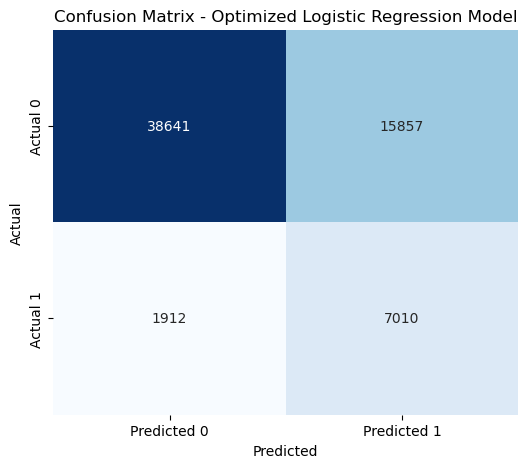

In [39]:
# Confusion matrix for GaussianNB
cm_df = pd.DataFrame(cm_lr_optimized_sm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

# Seaborn Confusion Matrix Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix - Optimized Logistic Regression Model')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()